In [2]:
from Models import mobilenetv2
import torch
import torch.optim as optim
import torch.nn as nn
from Dataloaders import dataloader_cifar10
from tqdm import tqdm

accuracy = []
_, test, _ = dataloader_cifar10.Dataloader_cifar10_val(train_batch=128, test_batch=100, seed=2024)
for i in range(1,9):
    model = mobilenetv2.MobileNetV2_together_n(num_classes=10, middle=i)
    model.load_state_dict(torch.load('model_together_' + str(i) +'.pth'))
    device = torch.device('cuda:0')
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        all_correct = 0
        for i, data in enumerate(test):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            outputs = torch.argmax(outputs, dim=1)
            correct = torch.sum(outputs == labels)
            all_correct += correct
        accuracy.append(all_correct.item()/10000)


Files already downloaded and verified
Files already downloaded and verified


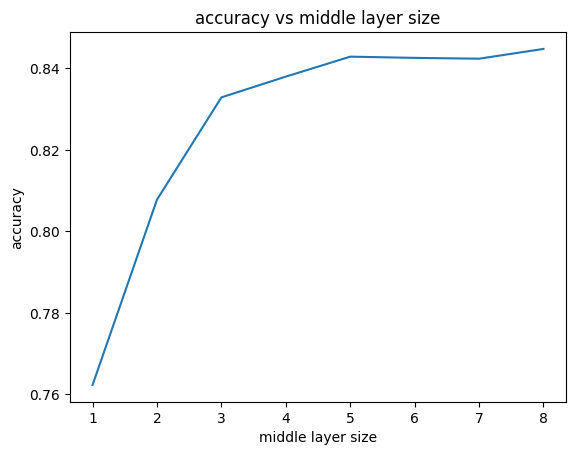

In [3]:
# plot acc vs middle layer size
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(1,9)
plt.plot(x, accuracy)
plt.xlabel('middle layer size')
plt.ylabel('accuracy')
plt.title('accuracy vs middle layer size')
plt.show()

In [13]:
from Models import mobilenetv2
import torch
import torch.optim as optim
import torch.nn as nn
from Dataloaders import dataloader_cifar10
from tqdm import tqdm

middle_accuracy = []
_, test, _ = dataloader_cifar10.Dataloader_cifar10_val(train_batch=128, test_batch=100, seed=2024)

middle_size = 8
client, server = mobilenetv2.mobilenetv2_splitter(num_classes=10,
                                                  weight_root='/home/tonypeng/Workspace1/adaptfilter/Adaptfilter/Weights/cifar-10',
                                                  device='cuda:0',partition=-1)

device = torch.device('cuda:0')
client = client.to(device)
server = server.to(device)
client = client.eval()
server = server.eval()

middle = mobilenetv2.MobileNetV2_middle(middle=middle_size)
middle.load_state_dict(torch.load('model_middle_' + str(middle_size) +'.pth'))
middle = middle.to(device)
middle = middle.eval()

correct = 0
with torch.no_grad():
    for i, data in enumerate(test):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = client(inputs)
        outputs = middle(outputs)
        outputs = server(outputs)
        outputs = torch.argmax(outputs, dim=1)
        correct += torch.sum(outputs == labels)
    middle_accuracy.append(correct.item()/10000)

print('middle accuracy:', middle_accuracy)

Files already downloaded and verified
Files already downloaded and verified
middle accuracy: [0.8394]
